In [1]:
import sys
import sklearn
import matplotlib
import numpy as np

In [2]:
from keras.datasets import mnist
#use of keras only for dataset
(x_train,y_train),(x_test,y_test)=mnist.load_data()

print('Training Data: {}'.format(x_train.shape))
print('Training Labels: {}'.format(y_train.shape))

Using TensorFlow backend.


Training Data: (60000, 28, 28)
Training Labels: (60000,)


In [3]:
print('Testing Data: {}'.format(x_test.shape))
print('Testing Labels: {}'.format(y_test.shape))


Testing Data: (10000, 28, 28)
Testing Labels: (10000,)


In [4]:
import matplotlib.pyplot as plt

# python magic function
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


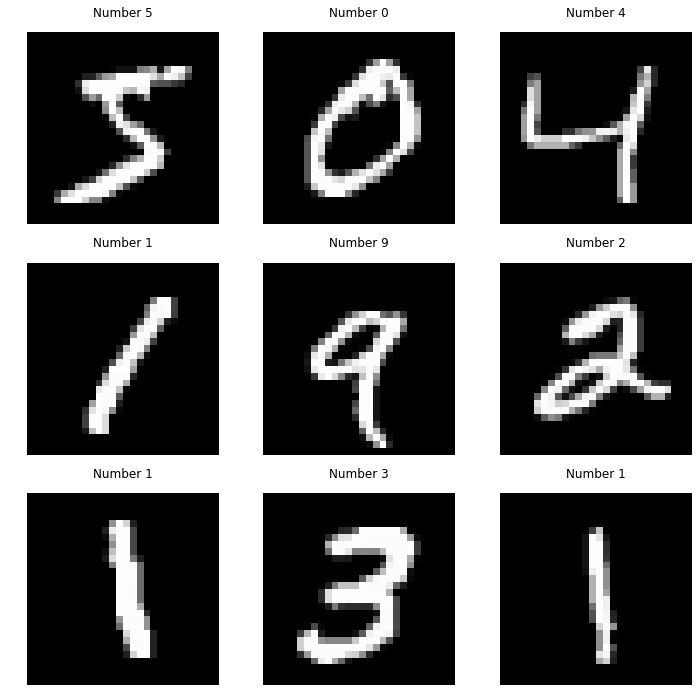

In [5]:
# create figure with 3x3 subplots using matplotlib.pyplot
fig,axs=plt.subplots(3,3,figsize=(12,12))
plt.gray()#cuz images are going to be black and white

#loop through subplots and add mnist images
for i,ax in enumerate(axs.flat):
    #flatten the axis so we can loop through with a single index
    ax.matshow(x_train[i])
    ax.axis('off')#remove tickmarks cuz they are images 
    ax.set_title('Number {}'.format(y_train[i]))
    
fig.show()    

through deep learning got 99%+ accuracy but with kmeans that much is not achievable:aim is to understand kmeans(a clustering algo) and high dimensional data
So if you want to do strictly classification on images deep learning is the way to go 

# Preprocessing the MNIST images
Images stored as NumPy arrays are 2-dimensional arrays. However, the K-means clustering algorithm provided by scikit-learn ingests 1-dimensional arrays; as a result, we will need to reshape each image.

Clustering algorithms almost always use 1-dimensional data. For example, if you were clustering a set of X, Y coordinates, each point would be passed to the clustering algorithm as a 1-dimensional array with a length of two (example: [2,4] or [-1, 4]). If you were using 3-dimensional data, the array would have a length of 3 (example: [2, 4, 1] or [-1, 4, 5]).

MNIST contains images that are 28 by 28 pixels; as a result, they will have a length of 784 once we reshape them into a 1-dimensional array.

In [6]:
#convert each image to 1D array
X=x_train.reshape(len(x_train),-1)#if -1,calculate new array length automatically
Y=y_train#already 1d array

#normalize the data to o-1 cuz value ranges from 0 to 255
X=X.astype(float)/255.

print(X.shape)
print(X[0].shape)

(60000, 784)
(784,)


#  K-Means Clustering
Due to the size of the MNIST dataset, we will use the mini-batch implementation of k-means clustering provided by scikit-learn. This will dramatically reduce the amount of time it takes to fit the algorithm to the data.

The MNIST dataset contains images of the integers 0 to 9. Thus, set the number of clusters to 10, one for each digit.

In [7]:
from sklearn.cluster import MiniBatchKMeans
#uses mini batches to solve and fit the training data much faster; imp. cuz we have 60k images
#but at the cost of accuracy
n_digits=len(np.unique(y_test))
print(n_digits)
#initialize Kmeans model
kmeans=MiniBatchKMeans(n_clusters=n_digits)

kmeans.fit(X)

10


MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=None, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

random state not set thus different results possible 

In [8]:
print(kmeans.labels_.shape)
kmeans.labels_[:20]

(60000,)


array([4, 3, 7, 2, 5, 9, 2, 0, 2, 6, 4, 2, 4, 1, 2, 6, 9, 6, 1, 6],
      dtype=int32)

here the label 4 (for first image),doesn't mean that the image was integer 4; it means that it was assigned to the 4th cluster

Also, as kmeans is unsupervised , it doesn't know what these clusters are supposed to represent,thus , we need to assign labels to each of these clusters

# Assigning Cluster Labels
K-means clustering is an unsupervised machine learning method; consequently, ***the labels assigned by our KMeans algorithm refer to the cluster each array was assigned to, not the actual target integer***.

To fix this, define  functions that will predict which integer corresponds to each cluster.

In [9]:
def infer_cluster_labels(kmeans, actual_labels):
    """
    Associates most probable label with each cluster in KMeans model
    
    returns: dictionary of clusters assigned to each label
    this is cuz if number of clusters>number of labels,multiple clusters will be assigned to single label
    """

    inferred_labels = {}

    for i in range(kmeans.n_clusters):#loop through the clusters

        # find index of points in cluster
        labels = []
        index = np.where(kmeans.labels_ == i)
        #find all the points that have been assigned to this cluster

        # append actual labels for each point in cluster
        labels.append(actual_labels[index])
        
        #so now for each cluster, we have list of all the points that are in this cluster
        #and we have added all of the actual labels for those points to this labels list
        
        # determine most common label; assign the cluster most common label that occurs in that cluster
        #creating a bincount for all of the label values that have been assigned into each cluster
        if len(labels[0]) == 1:
            counts = np.bincount(labels[0])#don't need squeeze function
        else:
            counts = np.bincount(np.squeeze(labels))

        # assign the cluster to a value in the inferred_labels dictionary
        #argmax returns int value for the maximum bincounts
        if np.argmax(counts) in inferred_labels:
            # append the new number to the existing array at this slot
            inferred_labels[np.argmax(counts)].append(i)#appends cluster label
        else:
            # create a new array in this slot
            inferred_labels[np.argmax(counts)] = [i]#i as list so we can append to it

       # print(labels)
       # print('Cluster: {}, label: {}'.format(i, np.argmax(counts)))
        
    return inferred_labels  

def infer_data_labels(X_labels, cluster_labels):
    """
    Determines label for each array of image, depending on the cluster it has been assigned to.
    returns: predicted labels for each array
    """
    
    # empty array of len(X)
    predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)
    
    for i, cluster in enumerate(X_labels):
        for key, value in cluster_labels.items():
            if cluster in value:#the cluster point was assined to is in the dictionary(the list clusters for each integer)
                predicted_labels[i] = key
                
    return predicted_labels

In [ ]:
#test the infer_cluster_labels() and infer_data_labels() 
cluster_labels=infer_cluster_labels(kmeans,Y)
X_clusters=kmeans.predict(X)
predicted_labels=infer_data_labels(X_clusters,cluster_labels)

print(predicted_labels[:20])
print(Y[:20])

# Optimizing and Evaluating the Clustering Algorithm
Since we are using this clustering algorithm for classification, accuracy is ultimately the most important metric; however, there are other metrics out there that can be applied directly to the clusters themselves, regardless of the associated labels. Two of these metrics that we will use are inertia and homogeneity.

Furthermore, earlier we made the assumption that K = 10 was the appropriate number of clusters; however, this might not be the case. Let's fit the K-means clustering algorithm with several different values of K, than evaluate the performance using our metrics.



In [ ]:
from sklearn import metrics

def calculate_matrics(estimator,data,labels):
    print('Number of clusters: {}'.format(estimator.n_clusters))
    print('Inertia: {}'.format(estimator.inertia_))
    print('Homogeneity: {}'.format(metrics.homogeneity_score(labels,estimator.labels_)))

In [ ]:
clusters=[10,16,36,34,144,256]

#test for different numbers of clusters
for n_clusters in clusters:
    estimator=MiniBatchKMeans(n_clusters=n_clusters)
    estimator.fit(X)
    
    calculate_matrics(estimator,X,Y)
    
    #determine predicted labels
    cluster_labels=infer_cluster_labels(estimator,Y)
    predicted_Y=infer_data_labels(estimator.labels_,cluster_labels)
    
    print('Accuracy: {}\n'.format(metrics.accuracy_score(Y,predicted_Y)))

In [ ]:
# test kmeans algorithm on testing dataset
# convert each image to 1 dimensional array
X_test=x_test.reshape(len(x_test),-1)

#normalize the data to 0 - 1
X_test=X_test.astype(float)/255.

# initialize and fit KMeans algorithm on training data
kmeans=MiniBatchKMeans(n_clusters=256)
kmeans.fit(X)
cluster_labels=infer_cluster_labels(kmeans,Y)

#predict labels for testinf data
test_clusters=kmeans.predict(X_test)
predicted_labels=infer_data_labels(kmeans.predict(X_test),cluster_labels)

# calculate and print accuracy
print('Accuracy: {}\n'.format(metrics.accuracy_score(y_test, predicted_labels)))

# Visualizing Cluster Centroids
The most representative point within each cluster is called the centroid. If we were dealing with X,Y points, the centroid would simply be a point on the graph. However, since we are using arrays of length 784, our centroid is also going to be an array of length 784. We can reshape this array back into a 28 by 28 pixel image and plot it.

These graphs will display the most representative image for each cluster.

In [ ]:
# Initialize and fit KMeans algorithm
kmeans = MiniBatchKMeans(n_clusters = 36)
kmeans.fit(X)

# record centroid values
centroids = kmeans.cluster_centers_

# reshape centroids into images
images = centroids.reshape(36, 28, 28)
images *= 255
images = images.astype(np.uint8)

# determine cluster labels
cluster_labels = infer_cluster_labels(kmeans, Y)

# create figure with subplots using matplotlib.pyplot
fig, axs = plt.subplots(6, 6, figsize = (20, 20))
plt.gray()

# loop through subplots and add centroid images
for i, ax in enumerate(axs.flat):
    
    # determine inferred label using cluster_labels dictionary
    for key, value in cluster_labels.items():
        if i in value:
            ax.set_title('Inferred Label: {}'.format(key))
    
    # add image to subplot
    ax.matshow(images[i])
    ax.axis('off')
    